In [1]:
import os, re, glob
import numpy as np
import imageio.v2 as iio

from tigre.utilities.geometry import Geometry
from tigre.algorithms import fdk  # FDK（解析法）

In [2]:
proj_dir = "figs/projections/chest/projections"
pattern    = "deg_*.png" 
a, b       = 0, 360             # 角度筛选范围（含端点；a>b 视为跨360°）

In [3]:
DSO = 600.0   # Distance Source to Origin
DSD = 1000.0  # Distance Source to Detector
nu, nv = 256, 256      # detector 像素数（宽u, 高v）必须与图片大小一致
du, dv = 1.0, 1.0      # 每像素尺寸（mm/px）——按你的模拟设定填写
nx, ny, nz = 256, 256, 256
dx, dy, dz = 1.0, 1.0, 1.0  # 每体素物理尺寸（mm）——与视野匹配
apply_neglog = False   # 若你的投影是强度 I（非线积分），建议开启 -log 变换
i0_mode      = "max"   # 估计 I0 的方式: "max" 或 "p99"（当 apply_neglog=True 生效）
eps          = 1e-6

In [13]:
angles_deg = np.arange(0, 360, 3, dtype=np.float32)

In [4]:
flip_u = False
flip_v = False

In [5]:
_angle_rgx = [
    re.compile(r"deg[_\-]?(\d{1,3})", re.IGNORECASE),
    re.compile(r"(\d{1,3})(?=\D*$)")
]
def extract_angle(path: str):
    base = os.path.basename(path)
    for rgx in _angle_rgx:
        m = rgx.search(base)
        if m:
            return int(m.group(1)) % 360
    return None

def in_range(theta: int, a: int, b: int) -> bool:
    return (a <= b and a <= theta <= b) or (a > b and (theta >= a or theta <= b))

def to_gray_float(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3:
        img = img[..., :3].astype(np.float32).mean(axis=2)
    else:
        img = img.astype(np.float32)
    return img

def neglog_transform(stack: np.ndarray, mode: str = "max", eps: float = 1e-6) -> np.ndarray:
    # stack: (nv, nu, nAngles), intensity I
    if mode == "max":
        I0 = np.max(stack)
    elif mode == "p99":
        I0 = np.percentile(stack, 99.0)
    else:
        raise ValueError("mode should be 'max' or 'p99'")
    I0 = max(I0, eps)
    return -np.log(np.clip(stack, eps, None) / I0)

In [7]:
files = sorted(glob.glob(os.path.join(proj_dir, pattern)))
pairs = []
for f in files:
    ang = extract_angle(f)
    if ang is not None and in_range(ang, a, b):
        pairs.append((ang, f))
if not pairs:
    raise RuntimeError("在指定角度范围内未匹配到投影图，请检查目录/文件名/角度范围。")

pairs.sort(key=lambda x: x[0])
thetas_deg = np.array([p[0] for p in pairs], dtype=np.float32)
thetas_rad = np.deg2rad(thetas_deg)

projs = np.empty((len(pairs), nv, nu), dtype=np.float32)
for i, (_, fp) in enumerate(pairs):
    img = to_gray_float(iio.imread(fp))
    assert img.shape == (nv, nu), f"{fp} shape={img.shape}, 期望 {(nv, nu)}"
    if flip_u: img = np.flip(img, axis=1)  # u 轴
    if flip_v: img = np.flip(img, axis=0)  # v 轴
    projs[i, :, :] = img

print(f"[Info] Loaded projections: shape={projs.shape}, angles=[{thetas_deg[0]}°, ..., {thetas_deg[-1]}°]")


[Info] Loaded projections: shape=(120, 256, 256), angles=[0.0°, ..., 357.0°]


In [8]:
# =========================
# TIGRE Geometry（必须与生成投影时一致）
# =========================
# 距离参数：务必是 1D numpy array

geo = Geometry()
geo.DSO = np.array([DSO], dtype=np.float32)
geo.DSD = np.array([DSD], dtype=np.float32)

# 探测器与体素：numpy array，且注意 TIGRE 的顺序 [u, v]
geo.nDetector = np.array([nu, nv], dtype=np.int32)       # [u, v]
geo.dDetector = np.array([du, dv], dtype=np.float32)     # [u, v]
geo.sDetector = geo.nDetector * geo.dDetector

geo.nVoxel = np.array([nx, ny, nz], dtype=np.int32)      # [x, y, z]
geo.dVoxel = np.array([dx, dy, dz], dtype=np.float32)
geo.sVoxel = geo.nVoxel * geo.dVoxel

geo.offOrigin   = np.array([0.0, 0.0, 0.0], dtype=np.float32)
geo.offDetector = np.array([0.0, 0.0], dtype=np.float32)

geo.mode = 'cone'

# 很多 Python 版本的 TIGRE 会在 __str__ 里访问这个字段
geo.accuracy = 0.5

In [9]:
print("[Info] Running FDK ...")
vol = fdk(projs, geo, thetas_rad)
print(f"[Done] Volume reconstructed: shape={vol.shape}, dtype={vol.dtype}")

[Info] Running FDK ...
TIGRE parameters
-----
Geometry parameters
Distance from source to detector (DSD) = [1000.] mm
Distance from source to origin (DSO)= [600.] mm
-----
Detector parameters
Number of pixels (nDetector) = [256 256]
Size of each pixel (dDetector) = [1. 1.] mm
Total size of the detector (sDetector) = [256. 256.] mm
-----
Image parameters
Number of voxels (nVoxel) = [256 256 256]
Total size of the image (sVoxel) = [256. 256. 256.] mm
Size of each voxel (dVoxel) = [1. 1. 1.] mm
-----
Offset correction parameters
Offset of image from origin (offOrigin) = [0. 0. 0.] mm
Offset of detector (offDetector) = [0. 0.] mm
-----
Auxillary parameters
Samples per pixel of forward projection (accuracy) = 0.5
(120, 256, 256)
[Done] Volume reconstructed: shape=(256, 256, 256), dtype=float32


In [12]:
from src.data.data_process.projection import get_projections

In [15]:
geo_dict = {
    # Distances
    "DSD": 1000.0,   # Distance Source Detector (mm)
    "DSO": 600.0,   # Distance Source Origin   (mm)

    # Detector parameters
    "nDetector": np.array([256, 256], dtype=np.int32),   # [nu, nv] = [width, height] (px)
    "dDetector": np.array([2.0, 2.0], dtype=np.float32), # [du, dv] (mm/px)

    # Image parameters
    "nVoxel": np.array([nx, ny, nz], dtype=np.int32),       # [nx, ny, nz]
    "dVoxel": np.array([dx, dy, dz], dtype=np.float32),     # [dx, dy, dz] (mm/vx)

    # Offsets
    "offOrigin":   np.array([0.0, 0.0, 0.0], dtype=np.float32),
    "offDetector": np.array([0.0, 0.0],       dtype=np.float32),

    # Mode & misc
    "mode": "cone",
    "accuracy": 0.5,
    "filter": "ram-lak",   # 供重建算法用，对 Ax 前向投影本身无影响

    # 可选（有的代码不会用到，但保留以便一致）
    "COR": 0.0,                                        # center of rotation (mm)
    "rotDetector": np.array([0.0, 0.0, 0.0], dtype=np.float32),  # (rad)
}



In [17]:
projs_vol = get_projections(vol, geo_dict, angles_deg)

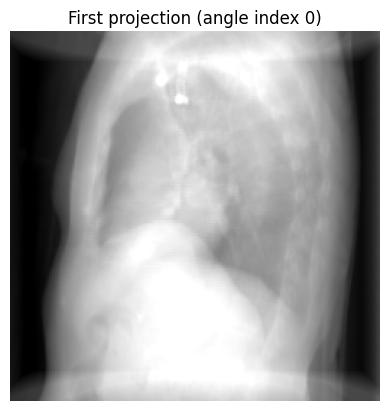

In [29]:
import matplotlib.pyplot as plt

# 假设 projs.shape == (nAngles, nv, nu)
plt.imshow(projs[0, :, :], cmap="gray")
plt.title("First projection (angle index 0)")
plt.axis("off")
plt.show()


In [22]:
from vis.proj.proj_vis import save_projs_png_uint8

In [23]:
paths = save_projs_png_uint8(
    projs=projs_vol,
    angles_deg=angles_deg,
    category="chest",       #  figs/projections/category/
    save_path="figs/degree/" + "projections_360/",         
    origin="lower",         # 如需倒置改 "lower"
)